In [ ]:
import os
!git clone https://github.com/Maria-Elisa-M/BW_prediction_keypoint.git

Mounted at /content/drive


In [14]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cross_decomposition import PLSRegression
import matplotlib.pyplot as plt

In [ ]:
os.chdir('BW_prediction_keypoint')
# Define directories
main_dir = 'depth'
# Load the dataset
BD = pd.read_csv(os.path.join(main_dir,"results","keypoints_results_bw.csv"))

In [22]:
# Define the columns for features and response
features = BD.columns[16:37]
Resp = BD.columns[37]

num_features = len(features)
print("Number of features:", num_features)

# Normalize the features
scaler = MinMaxScaler()
BD[features] = scaler.fit_transform(BD[features])

# Set seed for reproducibility
np.random.seed(123)

# Get unique IDs
ids = BD['cow'].unique()

# Initialize list for predictions
predictions = []

# Loop through each unique ID
for i in range(len(ids)):
    # Split data into training and test sets
    train = BD[BD['cow'] != ids[i]]
    test = BD[BD['cow'] == ids[i]]

    X_train = train[features]
    y_train = train[Resp]

    X_test = test[features]
    y_test = test[Resp]


    kf = KFold(n_splits=10, shuffle=True, random_state=123)

    # Initialize variables to store best hyperparameters and RMSE
    best_rmse = np.inf
    best_n_components = None

    # Iterate over possible number of components for PLS
    for n_components in range(1, num_features+1):
        fold_rmse = []

        for train_index, valid_index in kf.split(X_train):
            X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
            y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

            # Train the PLS model with current number of components
            model = PLSRegression(n_components=n_components)
            model.fit(X_tr, y_tr)

            # Perform prediction on the validation set
            predictions_valid = model.predict(X_val)

            rmse = np.sqrt(mean_squared_error(y_val, predictions_valid))
            fold_rmse.append(rmse)

        avg_rmse = np.mean(fold_rmse)

        # Check if current number of components is the best so far
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_n_components = n_components

    # Train the final model with the best number of components
    final_model = PLSRegression(n_components=best_n_components)
    final_model.fit(X_train, y_train)

    # Print the final model and best number of components
    print(f"Best number of components for ID {ids[i]}:", best_n_components)
    print(final_model)

    # Make predictions
    pred = pd.DataFrame({
        'Obs': y_test,
        'Pred': final_model.predict(X_test).flatten(),  # Flatten the predictions array
        'Num': test['cow'],
        'Best': str(best_n_components),
        'Day': test['day']
    })

    # Append to predictions list
    predictions.append(pred)

# Combine results into data frame
final_predictions_pls = pd.concat(predictions, ignore_index=True)

# Print the final predictions
print(final_predictions_pls)

# Mean Squared Error
mse = mean_squared_error(final_predictions_pls['Obs'], final_predictions_pls['Pred'])
print("Mean Squared Error:", mse)

# Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Root Mean Squared Error Percentage
rmsep = rmse / final_predictions_pls['Obs'].mean() * 100
print("Root Mean Squared Error %:", rmsep)

# Mean Absolute Error
mae = mean_absolute_error(final_predictions_pls['Obs'], final_predictions_pls['Pred'])
print("Mean Absolute Error:", mae)

# Predictive Correlation
correl = np.corrcoef(final_predictions_pls['Obs'], final_predictions_pls['Pred'])[0, 1] ** 2
print("Predictive Correlation:", correl)

# Save metrics in a DataFrame
metrics = pd.DataFrame({
    'Metric': [
        'Mean Squared Error',
        'Root Mean Squared Error',
        'Root Mean Squared Error %',
        'Mean Absolute Error',
        'Predictive Correlation'
    ],
    'Value': [mse, rmse, rmsep, mae, correl]
})

# Print the metrics DataFrame
print(metrics)



Number of features: 21
Best number of components for ID 4487: 3
PLSRegression(n_components=3)
Best number of components for ID 4489: 3
PLSRegression(n_components=3)
Best number of components for ID 4491: 3
PLSRegression(n_components=3)
Best number of components for ID 4492: 3
PLSRegression(n_components=3)
Best number of components for ID 4498: 4
PLSRegression(n_components=4)
Best number of components for ID 4499: 3
PLSRegression(n_components=3)
Best number of components for ID 4500: 3
PLSRegression(n_components=3)
Best number of components for ID 4503: 3
PLSRegression(n_components=3)
Best number of components for ID 4505: 3
PLSRegression(n_components=3)
Best number of components for ID 4507: 3
PLSRegression(n_components=3)
Best number of components for ID 4509: 3
PLSRegression(n_components=3)
Best number of components for ID 4511: 3
PLSRegression(n_components=3)
Best number of components for ID 4514: 3
PLSRegression(n_components=3)
Best number of components for ID 4525: 3
PLSRegression

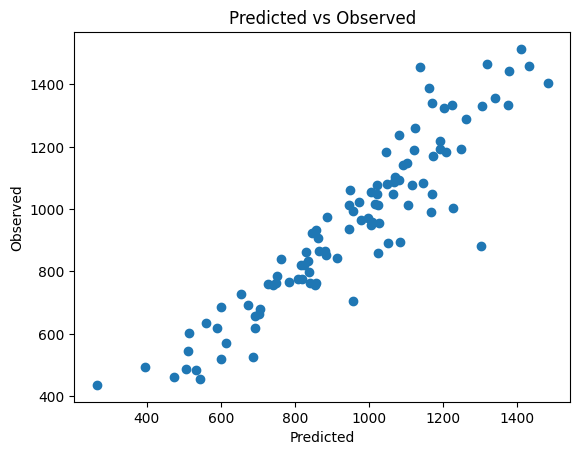

In [23]:
# Plot Predicted vs Observed
plt.scatter(final_predictions_pls['Pred'], final_predictions_pls['Obs'])
plt.xlabel('Predicted')
plt.ylabel('Observed')
plt.title('Predicted vs Observed')
plt.show()
